# Survey results processing

In this script, we:
- assemble the row survey data into a dataset for further media bias analysis,
- retrieve descriptive statistics of the assembled dataset.

To run this script, the following data files are needed (attached):
- annotations_final_notempty.xlsx
- sentences_final.xlsx
- biased_words_analysis.xlsx
- articles.xlsx
- labeled_dataset.xlsx
- annotators.csv

In [56]:
# data
import pandas as pd
import numpy as np

# misc
import os
import re
import time
import ast
import copy
from newsplease import NewsPlease

# statistics
import statistics
import statsmodels
from statsmodels.stats import inter_rater

# visualizations
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import plotly.express as px
from matplotlib import colors

## 1 Dataset assembling

In [2]:
# upload annotation results without rejected ones and without the following ones:
os.chdir('/Users/ladarudnitckaia/Desktop/Master Thesis/4. Survey/Results processing')
annotations = pd.read_excel("annotations_final_notempty.xlsx")
annotations['political_ideology_lcr'] = annotations['political_ideology'].apply(lambda x: "left" if x < -3
                                                                                else ("right" if x > 3 else "center"))
annotations["followed_news_outlets"] = annotations.followed_news_outlets.apply(lambda s: list(ast.literal_eval(s)))

annotations.head(2)

,Unnamed: 0,Unnamed: 0.1,survey_record_id,sentence_id,sentence_group_id,created_at,label,words,factual,group_id,...,mturk_id,age,gender,education,native_english_speaker,political_ideology,followed_news_outlets,news_check_frequency,survey_completed,political_ideology_lcr
0,0,19227,0045473f40ec42a2bd2ca0ee35df0b75,06e9e57e549d4dd48d8ac649ff81fd2e,67,2020-08-12 06:09:53,Non-biased,NaN,Entirely factual,67,...,Jonathan Daniel Garavito,29,Male,Bachelor’s degree,Native speaker,7,"[ABC News, MSNBC]",Every day,True,right
1,1,19228,0045473f40ec42a2bd2ca0ee35df0b75,07f2137fd3ae4dd2b5c990b93e5c2a62,67,2020-08-12 06:10:21,Non-biased,NaN,Expresses writer’s opinion,67,...,Jonathan Daniel Garavito,29,Male,Bachelor’s degree,Native speaker,7,"[ABC News, MSNBC]",Every day,True,right


In [3]:
os.chdir('/Users/ladarudnitckaia/Desktop/Master Thesis/4. Survey/Sentences collection')
all_sentences = pd.read_excel("sentences_final.xlsx")
all_sentences.head(2)

,sentence,news_link,outlet,topic,type,group_id,num_sent,Unnamed: 7
0,YouTube is making clear there will be no “birt...,https://eu.usatoday.com/story/tech/2020/02/03/...,usa-today,elections-2020,center,1,1,NaN
1,The increasingly bitter dispute between Americ...,https://www.nbcnews.com/news/sports/women-s-te...,msnbc,sport,left,1,1,NaN


In [4]:
# pivoting
turker_words = annotations.pivot(index='text', columns='survey_record_id', values='words')
turker_bias = annotations.pivot(index='text', columns='survey_record_id', values='label')
turker_opin = annotations.pivot(index='text', columns='survey_record_id', values='factual')

### 1.1 Labels - biased/non-biased

In [5]:
turker_bias["Biased"] = turker_bias.apply(lambda row: sum(row[1:len(turker_bias.columns)]=="Biased") ,axis=1)
turker_bias["Non-biased"] = turker_bias.apply(lambda row: sum(row[1:(len(turker_bias.columns)-1)]=="Non-biased") ,axis=1)
results_bias = turker_bias[["Biased", 'Non-biased']]
results_bias["Label_bias"] = results_bias.apply(lambda row: "Biased" if row["Biased"]>((row["Biased"]+row["Non-biased"])/2) else ("Non-biased" if row["Non-biased"]>((row["Biased"]+row["Non-biased"])/2) else "No agreement"), axis=1)

results_bias["Total_annotations"] = results_bias["Biased"] + results_bias["Non-biased"]

/Users/ladarudnitckaia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ladarudnitckaia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
results_bias.head(25)

survey_record_id,Biased,Non-biased,Label_bias,Total_annotations
text,,,,
"Gautney consented to this field, job, and city, so if she has an issue with compensation or cost of living, switching to a more lucrative field or cheaper place to live is a decision she should make for herself, not a decision that ought to be bailed out by unsuspecting taxpayers who played no role in the choice.",8,3,Biased,11
Trade jobs such as electricians or carpenters are in demand and provide steady salaries. Policymakers shouldn’t deter students who know a good job when they see it.,6,4,Biased,10
"While conservatives may find comfort in the old saw that those who aren’t liberal at 20 have no heart, and those who aren’t conservative at 40 have no brain, the truth, as Levin knows, is that those who are statists at 20 usually end up statists at 40. And he’s not content to allow time to take its uncertain political toll.",9,1,Biased,10
"""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change.",6,6,No agreement,12
"...immigrants as criminals and eugenics, all of which were once considered fringe and extreme. White nationalists embrace white supremacist and white separatist views.",6,4,Biased,10
"...we sounded the alarm in the early months of Trump’s presidency, when prime-time Fox News host Tucker Carlson began to experiment with segments that used euphemisms like “Western civilization” to package the idea that white people are inherently more civilized while people of color are a threat to national stability.",8,3,Biased,11
"A 10-hour hearing broadcast on the court’s website showed Sun, China's greatest ever swimmer, and one of its biggest sports stars, to be evasive at times under questioning that was hampered by severe translation issues between Chinese and English.",5,4,Biased,9
"A 60-foot chunk of the Ocean Cleanup device, deployed with much fanfare in the Great Pacific Garbage Patch in October, has broken off and the entire plastic collection system will now be towed back to port for an overhaul and upgrade.",5,5,No agreement,10
"A 70% majority of Americans view the economy as unfairly favoring those with power, and large majorities also say politicians, giant corporations, and wealthy individuals wield too much power over the economy, according to Pew Research Center.",5,6,Non-biased,11


In [54]:
# os.chdir('/Users/ladarudnitckaia/Desktop/Master Thesis/4. Survey/Results processing')
# results_bias.to_excel('results_bias.xlsx')

In [7]:
no_ag_bias = results_bias[results_bias['Label_bias']=='No agreement']
print("Out of", len(results_bias), len(no_ag_bias), "have no agreement.")

Out of 1700 149 have no agreement.


In [8]:
results_bias10 = results_bias[results_bias['Total_annotations']==10]

fk_bias = inter_rater.fleiss_kappa(results_bias10[["Biased","Non-biased"]], method='fleiss')

print("Fleiss Kappa for annotation on whether the sentence is biased/impartial:", 
      round(fk_bias,2), "(Fair agreement)")

Fleiss Kappa for annotation on whether the sentence is biased/impartial: 0.21 (Fair agreement)


### 1.2 Labels - opinionated/factual

In [9]:
turker_opin["Entirely factual"] = turker_opin.apply(lambda row: sum(row[1:len(turker_opin.columns)]=="Entirely factual") ,axis=1)
turker_opin["Somewhat factual but also opinionated"] = turker_opin.apply(lambda row: sum(row[1:(len(turker_opin.columns)-1)]=="Somewhat factual but also opinionated") ,axis=1)
turker_opin["Expresses writer’s opinion"] = turker_opin.apply(lambda row: sum(row[1:(len(turker_opin.columns)-2)]=="Expresses writer’s opinion") ,axis=1)

results_opin = turker_opin[["Entirely factual", 'Somewhat factual but also opinionated', "Expresses writer’s opinion"]]

results_opin["max_Label_opinion"] = results_opin.apply(lambda row: max(row["Entirely factual"],
                                                                      row["Somewhat factual but also opinionated"],
                                                                       row["Expresses writer’s opinion"]), axis=1)
results_opin["Label_opinion"] = results_opin.apply(lambda row: "No agreement" if ((row["Entirely factual"]==row["max_Label_opinion"] and row["Somewhat factual but also opinionated"]==row["max_Label_opinion"]) 
                                                   or (row["Entirely factual"]==row["max_Label_opinion"] and row["Expresses writer’s opinion"]==row["max_Label_opinion"])
                                                   or (row["Somewhat factual but also opinionated"]==row["max_Label_opinion"] and row["Expresses writer’s opinion"]==row["max_Label_opinion"]))
                                                   else ("Entirely factual" if row["Entirely factual"]==row["max_Label_opinion"]
                                                        else "Somewhat factual but also opinionated" if row["Somewhat factual but also opinionated"]==row["max_Label_opinion"]
                                                        else "Expresses writer’s opinion")
                                                   , axis=1)

results_opin = results_opin[["Entirely factual", "Somewhat factual but also opinionated", 
                             "Expresses writer’s opinion", "Label_opinion"]]

results_opin["Total_annotations"] = results_opin["Entirely factual"] + results_opin["Somewhat factual but also opinionated"] + results_opin["Expresses writer’s opinion"]


/Users/ladarudnitckaia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/ladarudnitckaia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [10]:
results_opin.head(15)

survey_record_id,Entirely factual,Somewhat factual but also opinionated,Expresses writer’s opinion,Label_opinion,Total_annotations
text,,,,,
"Gautney consented to this field, job, and city, so if she has an issue with compensation or cost of living, switching to a more lucrative field or cheaper place to live is a decision she should make for herself, not a decision that ought to be bailed out by unsuspecting taxpayers who played no role in the choice.",2,0,9,Expresses writer’s opinion,11
Trade jobs such as electricians or carpenters are in demand and provide steady salaries. Policymakers shouldn’t deter students who know a good job when they see it.,0,4,6,Expresses writer’s opinion,10
"While conservatives may find comfort in the old saw that those who aren’t liberal at 20 have no heart, and those who aren’t conservative at 40 have no brain, the truth, as Levin knows, is that those who are statists at 20 usually end up statists at 40. And he’s not content to allow time to take its uncertain political toll.",0,2,8,Expresses writer’s opinion,10
"""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change.",5,4,3,Entirely factual,12
"...immigrants as criminals and eugenics, all of which were once considered fringe and extreme. White nationalists embrace white supremacist and white separatist views.",2,2,6,Expresses writer’s opinion,10
"...we sounded the alarm in the early months of Trump’s presidency, when prime-time Fox News host Tucker Carlson began to experiment with segments that used euphemisms like “Western civilization” to package the idea that white people are inherently more civilized while people of color are a threat to national stability.",3,3,5,Expresses writer’s opinion,11
"A 10-hour hearing broadcast on the court’s website showed Sun, China's greatest ever swimmer, and one of its biggest sports stars, to be evasive at times under questioning that was hampered by severe translation issues between Chinese and English.",2,4,3,Somewhat factual but also opinionated,9
"A 60-foot chunk of the Ocean Cleanup device, deployed with much fanfare in the Great Pacific Garbage Patch in October, has broken off and the entire plastic collection system will now be towed back to port for an overhaul and upgrade.",4,4,2,No agreement,10
"A 70% majority of Americans view the economy as unfairly favoring those with power, and large majorities also say politicians, giant corporations, and wealthy individuals wield too much power over the economy, according to Pew Research Center.",8,1,2,Entirely factual,11


In [55]:
# os.chdir('/Users/ladarudnitckaia/Desktop/Master Thesis/4. Survey/Results processing')
# results_opin.to_excel('results_opin.xlsx')

In [11]:
no_ag_opin = results_opin[results_opin['Label_opinion']=='No agreement']
print("Out of", len(results_opin), len(no_ag_opin), "have no agreement.")

Out of 1700 174 have no agreement.


In [12]:
results_opin10 = results_opin[results_opin['Total_annotations']==10]

fk_opinion = inter_rater.fleiss_kappa(results_opin10[["Entirely factual", "Expresses writer’s opinion", 
                                                    "Somewhat factual but also opinionated"]], method='fleiss')

print("Fleiss Kappa for annotation on whether the sentence is opinionated/factual:", 
      round(fk_opinion,2), "(Slight agreement)")

Fleiss Kappa for annotation on whether the sentence is opinionated/factual: 0.16 (Slight agreement)


### 1.3 Biased words

#### 1.3.1 Count frequency of highlighted words

In [13]:
survey_codes = list(turker_words)
results_words = turker_words.copy(deep = True)

for survey in survey_codes: 
    # remove quotation marks, spaces and dots. Split string to list of selected words
    results_words[survey] = results_words[survey].apply(lambda x: re.sub(r'“', '', x) if pd.isna(x) == False else x)
    results_words[survey] = results_words[survey].apply(lambda x: re.sub(r'”', '', x) if pd.isna(x) == False else x)
    results_words[survey] = results_words[survey].apply(lambda x: re.sub(r'\.', '', x) if pd.isna(x) == False else x)
    results_words[survey] = results_words[survey].apply(lambda x: x.split(',') if pd.isna(x) == False else x)

results_words = results_words.where(pd.notnull(results_words), None)

In [14]:
results_words["Words_freq"] = [{} for _ in range(len(results_words))]

for ind in results_words.index: # iterate over each sentence
    for survey in survey_codes: # iterate over columns to include each survey
        if results_words[survey][ind] != None:
            for word in results_words[survey][ind]:
                word_ = word.strip() # remove whitespaces from the beginning and end
                if word_ in results_words["Words_freq"][ind]:
                    results_words["Words_freq"][ind][word_] += 1
                else:
                    results_words["Words_freq"][ind][word_] = 1

results_words = pd.merge(results_words, results_bias, left_index = True, right_index = True, how='left')

results_words = results_words[["Words_freq", "Total_annotations"]]
results_words = results_words.reset_index()
results_words.head(25)

survey_record_id,text,Words_freq,Total_annotations
0,"Gautney consented to this field, job, and cit...","{'bailed out': 3, 'that ought to be': 1, 'chea...",11
1,Trade jobs such as electricians or carpenters...,"{'Policymakers shouldn’t deter': 1, 'deter': 4...",10
2,While conservatives may find comfort in the o...,"{'no hear': 1, 'no brain': 2, 'old saw': 2, 'h...",10
3,"""Orange Is the New Black"" star Yael Stone is r...","{'renouncing': 4, 'Australia': 1, 'fight': 2, ...",12
4,"...immigrants as criminals and eugenics, all o...","{'embrace': 2, 'immigrants as criminals': 2, '...",10
5,...we sounded the alarm in the early months of...,"{'euphemisms': 3, 'sounded the alarm': 3, 'pac...",11
6,A 10-hour hearing broadcast on the court’s web...,"{'evasive at times': 1, 'greatest ever': 4, 'g...",9
7,"A 60-foot chunk of the Ocean Cleanup device, d...","{'fanfare': 2, 'with much fanfare': 1, 'entire...",10
8,A 70% majority of Americans view the economy a...,"{'large majorities': 1, 'Pew Research Center':...",11
9,A Catholic priest in Rhode Island who barred s...,"{'abortio': 1, 'abortion is worse than pedophi...",12


In [15]:
def update_annotations(d):
    d_upd = {}
    for p in d:
        w_list = p.split(" ")
        for w in w_list:
            if w in d_upd:
                d_upd[w]+=d[p]
            else:
                d_upd[w]=d[p]
    return(d_upd)

results_words["biased_upd"] = results_words.apply(lambda row: update_annotations(row['Words_freq']), axis=1)
results_words['words_freq_manual'] = None

# biased_words_analysis.to_excel("biased_words_analysis.xlsx")

We manually go through all the sentences, correct mistakes in annotations, and decide on the reasonable threshold. Corrected annotations are in the column "words_freq_manual". The threshold is chosen to be 4.

#### 1.3.2 Select only words highlighted at least 4 times

In [16]:
# words selected more than 4 times
def list_biased_words(dic):
    biased = {k: v for k, v in dic.items() if v >= 4}
    biased = list(biased.keys())
    return(biased)

In [17]:
os.chdir('/Users/ladarudnitckaia/Desktop/Master Thesis/4. Survey/Results processing')
annotations_words = pd.read_excel("biased_words_analysis.xlsx")
annotations_words['words_freq_manual_dic']=annotations_words['words_freq_manual'].apply(lambda s: ast.literal_eval(s))
annotations_words['biased_words4'] = annotations_words.apply(lambda row: list_biased_words(row['words_freq_manual_dic']), axis=1)
annotations_biased_words = annotations_words[['text','Total_annotations','biased_words4']]
annotations_biased_words.head(10)

,text,Total_annotations,biased_words4
0,"Gautney consented to this field, job, and cit...",11,"[bailed, unsuspecting]"
1,Trade jobs such as electricians or carpenters...,10,[deter]
2,While conservatives may find comfort in the o...,10,"[brain, statists]"
3,"""Orange Is the New Black"" star Yael Stone is r...",12,[renouncing]
4,"...immigrants as criminals and eugenics, all o...",10,[]
5,...we sounded the alarm in the early months of...,11,"[alarm, inherently, threat]"
6,A 10-hour hearing broadcast on the court’s web...,9,"[evasive, greatest, ever]"
7,"A 60-foot chunk of the Ocean Cleanup device, d...",10,[fanfare]
8,A 70% majority of Americans view the economy a...,11,[unfairly]
9,A Catholic priest in Rhode Island who barred s...,12,"[abortion, worse, than, pedophilia]"


### 1.4 Final labeled sentences

In [35]:
# download articles
# articles = all_sentences.replace({np.nan: None})
# articles['article'] = None

# for index, row in articles.iterrows():
#     if row['news_link'] != None:
#         try:
#             print(index)
#             articles.at[index,'article'] = NewsPlease.from_url(row['news_link']).maintext
#         except:
#             print(index, "An exception occurred")
            
# articles = articles[['sentence','article']]

# articles.to_excel("articles.xlsx")

In [18]:
os.chdir('/Users/ladarudnitckaia/Desktop/Master Thesis/4. Survey/Results processing')
all_articles = pd.read_excel("articles.xlsx")

In [19]:
labeled_sentences = pd.merge(all_sentences, results_bias,
                           left_on = 'sentence', right_index = True,
                           how='left')
labeled_sentences = pd.merge(labeled_sentences, results_opin,
                           left_on = 'sentence', right_index = True,
                           how='left')
labeled_sentences = pd.merge(labeled_sentences, annotations_biased_words,
                           left_on = 'sentence', right_on = 'text',
                           how='left')
labeled_sentences = pd.merge(labeled_sentences, all_articles,
                           left_on = 'sentence', right_on = 'sentence',
                           how='left')
labeled_sentences = labeled_sentences[['sentence',
 'news_link',
 'outlet',
 'topic',
 'type',
 'group_id',
 'num_sent',
 'Label_bias',
 'Label_opinion',
 'biased_words4',
 'article']]

print('len:', len(labeled_sentences))
print('Is there missing values?', labeled_sentences.isnull().values.any())
print('Number of missing values:\n', labeled_sentences.isnull().sum())

len: 1700
Is there missing values? True
Number of missing values:
 sentence           0
news_link          0
outlet             0
topic              0
type               0
group_id           0
num_sent           0
Label_bias         0
Label_opinion      0
biased_words4      0
article          100
dtype: int64


In [20]:
labeled_sentences.head(3)

,sentence,news_link,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,biased_words4,article
0,YouTube is making clear there will be no “birt...,https://eu.usatoday.com/story/tech/2020/02/03/...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,"[belated, birtherism]",YouTube says no ‘deepfakes’ or ‘birther’ video...
1,The increasingly bitter dispute between Americ...,https://www.nbcnews.com/news/sports/women-s-te...,msnbc,sport,left,1,1,Non-biased,Entirely factual,[bitter],"FRISCO, Texas — The increasingly bitter disput..."
2,So while there may be a humanitarian crisis dr...,https://www.alternet.org/2019/01/here-are-5-of...,alternet,immigration,left,1,1,Biased,Expresses writer’s opinion,[crisis],Speaking to the country for the first time fro...


In [28]:
# os.chdir('/Users/ladarudnitckaia/Desktop/Master Thesis/4. Survey/Results processing')
# labeled_sentences.to_excel('labeled_dataset.xlsx')

## 2 Descriptive statistics

### 2.1 Dataset exploration

In [21]:
os.chdir('/Users/ladarudnitckaia/Desktop/Master Thesis/4. Survey/Results processing')
sentences = pd.read_excel('labeled_dataset.xlsx')

In [22]:
sentences.head(3)

,Unnamed: 0,sentence,news_link,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,article,biased_words4
0,0,YouTube is making clear there will be no “birt...,https://eu.usatoday.com/story/tech/2020/02/03/...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,YouTube says no ‘deepfakes’ or ‘birther’ video...,"['belated', 'birtherism']"
1,1,The increasingly bitter dispute between Americ...,https://www.nbcnews.com/news/sports/women-s-te...,msnbc,sport,left,1,1,Non-biased,Entirely factual,"FRISCO, Texas — The increasingly bitter disput...",['bitter']
2,2,So while there may be a humanitarian crisis dr...,https://www.alternet.org/2019/01/here-are-5-of...,alternet,immigration,left,1,1,Biased,Expresses writer’s opinion,Speaking to the country for the first time fro...,['crisis']


In [23]:
# outlets
types_outlets = sentences.groupby(['type','outlet'])[['sentence']].count()
types_outlets = types_outlets.reset_index()
types_outlets = types_outlets.rename(columns={"sentence": "num_sentences"})
types_outlets

,type,outlet,num_sentences
0,center,reuters,158
1,center,usa-today,157
2,left,alternet,338
3,left,huffpost,114
4,left,msnbc,242
5,right,breitbart,377
6,right,federalist,203
7,right,fox-news,111


In [25]:
fig = px.sunburst(data_frame = types_outlets,
                  path = ['type', 'outlet'],
                  values = 'num_sentences',
                  color='type',
                  color_discrete_map={'center':'thistle', 'left':'steelblue','right':'indianred'})
fig.update_traces(textfont_size=20)
fig.show()

In [30]:
# topics
topics = sentences.groupby(['topic'])[['sentence']].count()
topics = topics.reset_index()
topics = topics.rename(columns={"sentence": "num_sentences"})
topics = topics.replace('international-politics-and-world-news', 'int.-politics-&-world-news')

topics

,topic,num_sentences
0,abortion,126
1,coronavirus,122
2,elections-2020,111
3,environment,135
4,gender,128
5,gun-control,124
6,immigration,122
7,int.-politics-&-world-news,88
8,middle-class,118
9,sport,126


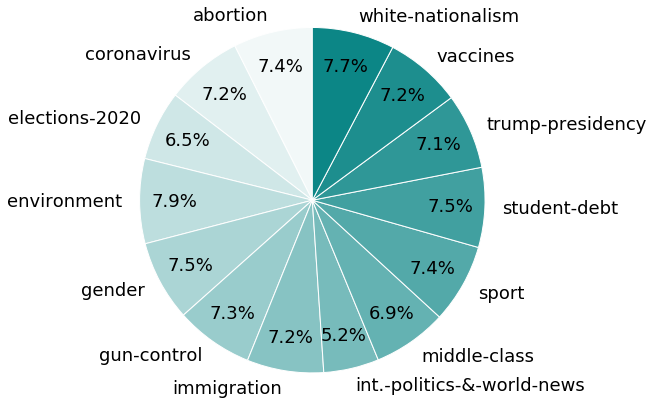

In [31]:
alphas = np.linspace(0.05, 0.95, 14)
teal_rgba = np.array([np.array(list(colors.to_rgba('teal', alpha=None))),]*14)
teal_rgba[:, 3] = alphas
teal_rgba

def my_autopct(pct):
    return ('%.1f%%' % pct) if pct > 3 else ''

fig1, ax1 = plt.subplots(figsize=(10,7))
my_pie = ax1.pie(topics.num_sentences, labels=topics.topic,
        startangle=90, textprops={'fontsize': 18}, #labeldistance=None,
        autopct=my_autopct, pctdistance=0.8,
       colors=teal_rgba)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.legend(loc='upper right') #, bbox_to_anchor=(1.24, 0.95))

for pie_wedge in my_pie[0]:
    pie_wedge.set_edgecolor('white')

plt.show()

### 2.2 Who are our annotators?

In [34]:
os.chdir('/Users/ladarudnitckaia/Desktop/Master Thesis/4. Survey/Results processing')
all_annotators = pd.read_csv('annotators.csv')

annotators = all_annotators[all_annotators.id.isin(set(annotations.survey_record_id))]
annotators = annotators.drop_duplicates(subset=['mturk_id'])
annotators['political_ideology_lcr'] = annotators['political_ideology'].apply(lambda x: "left" if x < -3
                                                                                else ("right" if x > 3 else "center"))
annotators["followed_news_outlets"] = annotators.followed_news_outlets.apply(lambda s: list(ast.literal_eval(s)))

print('Total number of annotators:', len(annotators))

Total number of annotators: 784


In [35]:
annotators.head(2)

,id,mturk_id,age,gender,education,native_english_speaker,political_ideology,followed_news_outlets,news_check_frequency,survey_completed,political_ideology_lcr
0,cd0bc7394bd8486c825c452de1640d06,A4W9APAHFWVLO,39,Male,Bachelor’s degree,Native speaker,-7,[ABC News],Several times per week,True,left
1,aef3ca5391f04e788d6f11a0602c17bb,A2MFMT03E21ZIT,29,Female,Some college,Native speaker,-10,"[CNN, MSNBC]",Never,True,left


In [36]:
# age distribution
annotators_age = annotators.groupby(['age'])[['id']].count()
annotators_age = annotators_age.reset_index()
annotators_age = annotators_age.rename(columns={"id": "num_participants"})
annotators_age['age_bins'] = pd.cut(x=annotators_age['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80])

annotators_age = annotators_age[annotators_age['age']>0]

annotators_age = annotators_age.groupby(['age_bins'])[['num_participants']].sum()
annotators_age = annotators_age.reset_index()
annotators_age

,age_bins,num_participants
0,"(0, 20]",6
1,"(20, 30]",236
2,"(30, 40]",292
3,"(40, 50]",141
4,"(50, 60]",76
5,"(60, 70]",31
6,"(70, 80]",1


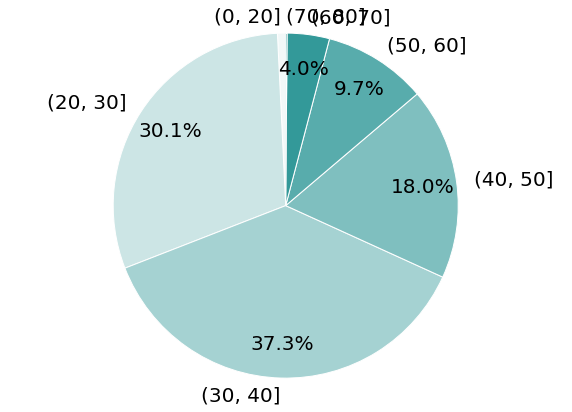

In [38]:
alphas = np.linspace(0.05, 0.95, 7)
teal_rgba = np.array([np.array(list(colors.to_rgba('teal', alpha=None))),]*7)
teal_rgba[:, 3] = alphas
teal_rgba

def my_autopct(pct):
    return ('%.1f%%' % pct) if pct > 3 else ''

fig1, ax1 = plt.subplots(figsize=(10,7))
my_pie = ax1.pie(annotators_age.num_participants, labels=annotators_age.age_bins,
        startangle=90, textprops={'fontsize': 20}, #labeldistance=None,
        autopct=my_autopct, pctdistance=0.8,
       colors=teal_rgba)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.legend(loc='upper right') #, bbox_to_anchor=(1.24, 0.95))

for pie_wedge in my_pie[0]:
    pie_wedge.set_edgecolor('white')

plt.show()

In [39]:
# gender distribution
annotators_gender = annotators.groupby(['gender'])[['id']].count()
annotators_gender = annotators_gender.reset_index()
annotators_gender = annotators_gender.rename(columns={"id": "num_participants"})
annotators_gender

,gender,num_participants
0,Female,334
1,Male,443
2,Other/Prefer not to say,7


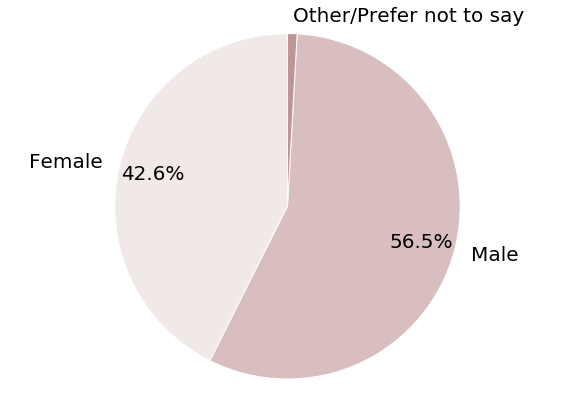

In [40]:
alphas = np.linspace(0.2, 0.95, 3)
teal_rgba = np.array([np.array(list(colors.to_rgba('rosybrown', alpha=None))),]*3)
teal_rgba[:, 3] = alphas
teal_rgba

def my_autopct(pct):
    return ('%.1f%%' % pct) if pct > 3 else ''

fig1, ax1 = plt.subplots(figsize=(10,7))
my_pie = ax1.pie(annotators_gender.num_participants, labels=annotators_gender.gender,
        startangle=90, textprops={'fontsize': 20}, #labeldistance=None,
        autopct=my_autopct, pctdistance=0.8,
       colors=teal_rgba)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.legend(loc='upper right') #, bbox_to_anchor=(1.24, 0.95))

for pie_wedge in my_pie[0]:
    pie_wedge.set_edgecolor('white')

plt.show()

In [41]:
# education
annotators_edu = annotators.groupby(['education'])[['id']].count()
annotators_edu = annotators_edu.reset_index()
annotators_edu = annotators_edu.rename(columns={"id": "num_participants"})
annotators_edu['sorting'] = [5,6,7,2,8,4,1,3]
annotators_edu = annotators_edu.sort_values(by=['sorting']).reset_index()
annotators_edu = annotators_edu[['education','num_participants']]
annotators_edu

,education,num_participants
0,Some high school,7
1,High school graduate,64
2,Vocational or technical school,18
3,Some college,120
4,Associate degree,78
5,Bachelor’s degree,387
6,Graduate work,107
7,I prefer not to say,3


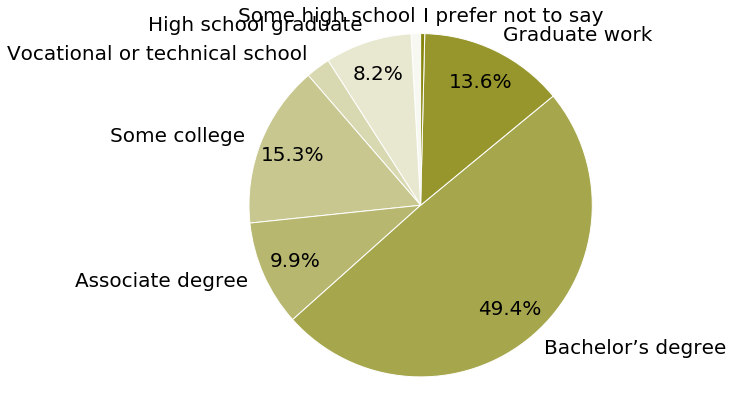

In [42]:
alphas = np.linspace(0.05, 0.95, 8)
teal_rgba = np.array([np.array(list(colors.to_rgba('olive', alpha=None))),]*8)
teal_rgba[:, 3] = alphas
teal_rgba

def my_autopct(pct):
    return ('%.1f%%' % pct) if pct > 3 else ''

fig1, ax1 = plt.subplots(figsize=(10,7))
my_pie = ax1.pie(annotators_edu.num_participants, labels=annotators_edu.education,
        startangle=90, textprops={'fontsize': 20}, #labeldistance=None,
        autopct=my_autopct, pctdistance=0.8,
       colors=teal_rgba)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.legend(loc='upper right', bbox_to_anchor=(1.15, 0.95))

for pie_wedge in my_pie[0]:
    pie_wedge.set_edgecolor('white')

plt.show()

In [43]:
# english knowledge
annotators_eng = annotators.groupby(['native_english_speaker'])[['id']].count()
annotators_eng = annotators_eng.reset_index()
annotators_eng = annotators_eng.rename(columns={"id": "num_participants"})
annotators_eng

,native_english_speaker,num_participants
0,Native speaker,761
1,Near-native speaker,22
2,Non-native speaker,1


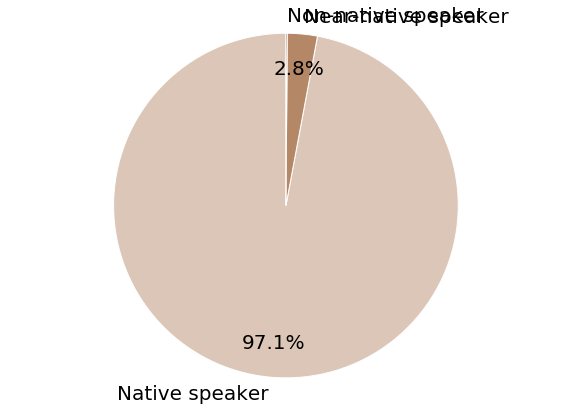

In [44]:
alphas = np.linspace(0.3, 0.99, 3)
teal_rgba = np.array([np.array(list(colors.to_rgba('saddlebrown', alpha=None))),]*3)
teal_rgba[:, 3] = alphas
teal_rgba

def my_autopct(pct):
    return ('%.1f%%' % pct) if pct > 2 else ''

fig1, ax1 = plt.subplots(figsize=(10,7))
my_pie = ax1.pie(annotators_eng.num_participants, labels=annotators_eng.native_english_speaker,
        startangle=90, textprops={'fontsize': 20}, #labeldistance=None,
        autopct=my_autopct, pctdistance=0.8,
       colors=teal_rgba)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.legend(loc='upper right', bbox_to_anchor=(1.15, 0.95))

for pie_wedge in my_pie[0]:
    pie_wedge.set_edgecolor('white')

plt.show()

In [47]:
# political orientation
annotators_polit = annotators.groupby(['political_ideology_lcr'])[['id']].count()
annotators_polit = annotators_polit.reset_index()
annotators_polit = annotators_polit.rename(columns={"id": "num_participants"})
annotators_polit['sorting'] = [2, 1, 3]
annotators_polit = annotators_polit.sort_values(by=['sorting']).reset_index()
annotators_polit = annotators_polit[['political_ideology_lcr','num_participants']]
annotators_polit = annotators_polit.replace('left', 'liberal')
annotators_polit = annotators_polit.replace('right', 'conservative')
annotators_polit

,political_ideology_lcr,num_participants
0,liberal,347
1,center,228
2,conservative,209


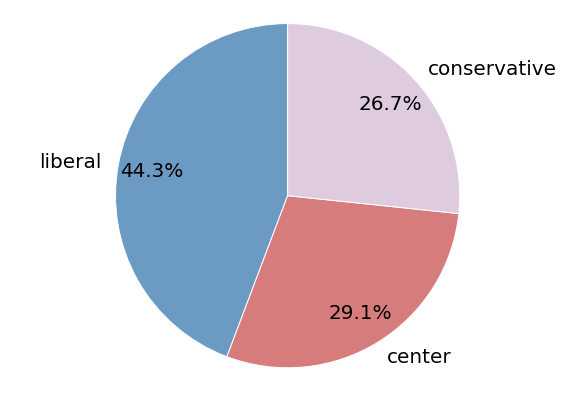

In [48]:
cols = np.array([
    np.array(colors.to_rgba('steelblue', alpha=0.8)),
    np.array(colors.to_rgba('indianred', alpha=0.8)),
    np.array(colors.to_rgba('thistle', alpha=0.8))])

def my_autopct(pct):
    return ('%.1f%%' % pct) if pct > 2 else ''

fig1, ax1 = plt.subplots(figsize=(10,7))
my_pie = ax1.pie(annotators_polit.num_participants, labels=annotators_polit.political_ideology_lcr,
        startangle=90, textprops={'fontsize': 20}, #labeldistance=None,
        autopct=my_autopct, pctdistance=0.8,
       colors=cols)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.legend(loc='upper right', bbox_to_anchor=(1.15, 0.95))

for pie_wedge in my_pie[0]:
    pie_wedge.set_edgecolor('white')

plt.show()

In [49]:
# followed news outlets
all_outlets = []
all_outlets_freq = {}

for ind in annotators.index:
    #print(type(annotators['followed_news_outlets'][ind]))
    for outlet in annotators['followed_news_outlets'][ind]:
        if outlet not in all_outlets:
            all_outlets.append(outlet)
            all_outlets_freq[outlet]=1
        else:
            all_outlets_freq[outlet]+=1
            
all_outlets_freq_filt = {}
all_outlets_freq_filt['misc']=0

for outlet in all_outlets_freq:
    if all_outlets_freq[outlet] > 5:
        all_outlets_freq_filt[outlet]=all_outlets_freq[outlet]
    else:
        all_outlets_freq_filt['misc']+=1

all_outlets_freq_filt

# pd
annotators_outlets = pd.DataFrame.from_dict(all_outlets_freq_filt, orient='index')
annotators_outlets = annotators_outlets.reset_index()
annotators_outlets = annotators_outlets.rename(columns={"index": "news_outlet",
                                                        0:"num_participants"})

# add slant from allsides
slant_allsides_dict = {'misc':'misc',
 'ABC News':'left',
 'CNN':'left',
 'MSNBC':'left',
 'The Washington Post':'left',
 'New York Post':'right',
 'New York Times':'left',
 'NPR':'center',
 'Fox News':'right',
 'Breitbart':'right',
 'The Wall Street Journal':'right',
 'Business Insider':'center',
 'Reuters':'center',
 'The Guardian':'left',
 'CBS News':'left',
 'USA Today':'center',
 'Time magazine':'left',
 'Vice':'left',
 'BuzzFeed':'left',
 'Huffington Post':'left',
 'The Federalist':'right',
 'BBC':'center'}

slant_allsides = pd.DataFrame.from_dict(slant_allsides_dict, orient='index')
slant_allsides = slant_allsides.reset_index()
slant_allsides = slant_allsides.rename(columns={"index": "news_outlet",
                                                        0:"slant_allsides"})

annotators_outlets = pd.merge(annotators_outlets, slant_allsides,
                             left_on='news_outlet', right_on='news_outlet', how='left')
annotators_outlets

,news_outlet,num_participants,slant_allsides
0,misc,74,misc
1,ABC News,140,left
2,CNN,367,left
3,MSNBC,138,left
4,The Washington Post,201,left
5,New York Post,98,right
6,New York Times,312,left
7,NPR,28,center
8,Fox News,262,right
9,Breitbart,34,right


In [51]:
fig = px.sunburst(data_frame = annotators_outlets,
                  path = ['slant_allsides', 'news_outlet'],
                  values = 'num_participants',
                  color='slant_allsides',
                  color_discrete_map={'center':'thistle', 'left':'steelblue',
                                      'right':'indianred', 'misc':'dimgray'})
fig.update_traces(textfont_size=20)
fig.show()

In [52]:
# news consumption frequency
annotators_cons = annotators.groupby(['news_check_frequency'])[['id']].count()
annotators_cons = annotators_cons.reset_index()
annotators_cons = annotators_cons.rename(columns={"id": "num_participants"})
annotators_cons['sorting'] = [4, 0, 5, 2, 3, 1]
annotators_cons = annotators_cons.sort_values(by=['sorting']).reset_index()
annotators_cons = annotators_cons[['news_check_frequency','num_participants']]
annotators_cons

,news_check_frequency,num_participants
0,Never,8
1,Very rarely,35
2,Several times per month,51
3,Several times per week,145
4,Every day,364
5,Several times per day,181


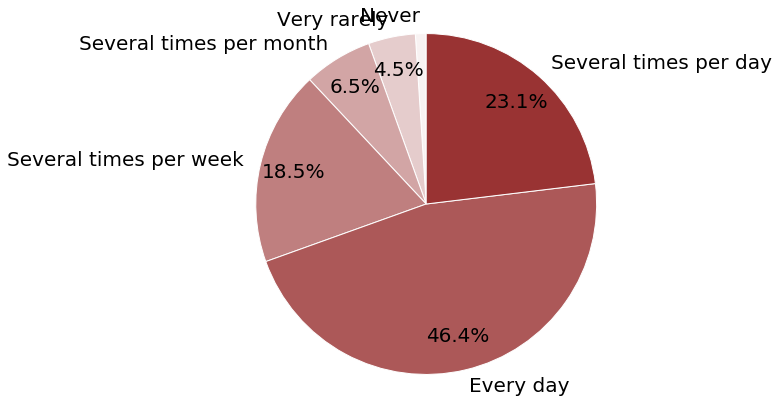

In [55]:
alphas = np.linspace(0.05, 0.8, 6)
teal_rgba = np.array([np.array(list(colors.to_rgba('maroon', alpha=None))),]*6)
teal_rgba[:, 3] = alphas
teal_rgba

def my_autopct(pct):
    return ('%.1f%%' % pct) if pct > 2 else ''

fig1, ax1 = plt.subplots(figsize=(10,7))
my_pie = ax1.pie(annotators_cons.num_participants, labels=annotators_cons.news_check_frequency,
        startangle=90, textprops={'fontsize': 20}, #labeldistance=None,
        autopct=my_autopct, pctdistance=0.8,
       colors=teal_rgba)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.legend(loc='upper right', bbox_to_anchor=(1.15, 0.95))

for pie_wedge in my_pie[0]:
    pie_wedge.set_edgecolor('white')

plt.show()